In [1]:
import findspark
# findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('spark').getOrCreate()

### 01-Business understanding
Business objectives:<br>
Deeply understand the environmental impact, focusing on climate change and global warming, from the agri-food industry.<br>
Provide evidence of policy setting to reduce the CO2 emissions from the agri-food sector.<br><br>
Data mining objectives:<br>
Examine the correlation between carbon dioxide (CO2) emissions within the agri-food sector and the subsequent temperature rise.<br>
Analyse the influence of various countries based on aggregated data on emissions and temperature change.<br>
Identify the countries with the highest average temperature increase by year and analyse their contributions to the overall environmental impact.<br>

### 02-Data understanding
Load Dataset

In [2]:
emission_df = spark.read.csv('G:/uoa/INFOSYS722/assignments/mydataset/Agrifood_co2_emission.csv', header=True)
population_df = spark.read.csv('G:/uoa/INFOSYS722/assignments/mydataset/Agrifood_co2_population.csv', header=True)


In [3]:
emission_df.show()

+-----------+----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+
|       Area|Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|    IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emis

In [4]:
population_df.show()

+-----------+----+----------------+----------------+-----------------------+-------------------------+--------------+-------------------+
|       Area|Year|Rural population|Urban population|Total Population - Male|Total Population - Female|total_emission|Average Temperature|
+-----------+----+----------------+----------------+-----------------------+-------------------------+--------------+-------------------+
|Afghanistan|1990|         9655167|         2593947|              5348387.0|                5346409.0|   2198.963539|        0.536166667|
|Afghanistan|1991|        10230490|         2763167|              5372959.0|                5372208.0|   2323.876629|        0.020666667|
|Afghanistan|1992|        10995568|         2985663|              6028494.0|                6028939.0|   2356.304229|       -0.259583333|
|Afghanistan|1993|        11858090|         3237009|              7003641.0|                7000119.0|   2368.470529|        0.101916667|
|Afghanistan|1994|        12690115

In [5]:
from pyspark.sql.types import DoubleType

for col in emission_df.columns:
    if col != 'Area':
        emission_df = emission_df.withColumn(col, emission_df[col].cast(DoubleType()))

emission_df.printSchema()

root
 |-- Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Savanna fires: double (nullable = true)
 |-- Forest fires: double (nullable = true)
 |-- Crop Residues: double (nullable = true)
 |-- Rice Cultivation: double (nullable = true)
 |-- Drained organic soils (CO2): double (nullable = true)
 |-- Pesticides Manufacturing: double (nullable = true)
 |-- Food Transport: double (nullable = true)
 |-- Forestland: double (nullable = true)
 |-- Net Forest conversion: double (nullable = true)
 |-- Food Household Consumption: double (nullable = true)
 |-- Food Retail: double (nullable = true)
 |-- On-farm Electricity Use: double (nullable = true)
 |-- Food Packaging: double (nullable = true)
 |-- Agrifood Systems Waste Disposal: double (nullable = true)
 |-- Food Processing: double (nullable = true)
 |-- Fertilizers Manufacturing: double (nullable = true)
 |-- IPPU: double (nullable = true)
 |-- Manure applied to Soils: double (nullable = true)
 |-- Manure left on Pastu

In [6]:
for col in population_df.columns:
    if col != 'Area':
        population_df = population_df.withColumn(col, population_df[col].cast(DoubleType()))

population_df.printSchema()

root
 |-- Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Rural population: double (nullable = true)
 |-- Urban population: double (nullable = true)
 |-- Total Population - Male: double (nullable = true)
 |-- Total Population - Female: double (nullable = true)
 |-- total_emission: double (nullable = true)
 |-- Average Temperature: double (nullable = true)



Explore Data

In [7]:
from pyspark.sql.functions import format_number

In [8]:
emission_desc = emission_df.describe()
population_desc = population_df.describe()

In [9]:
emission_desc.show()

+-------+-----------+------------------+------------------+-----------------+------------------+------------------+---------------------------+------------------------+------------------+-------------------+---------------------+--------------------------+-----------------+-----------------------+------------------+-------------------------------+------------------+-------------------------+------------------+-----------------------+----------------------+------------------+----------------------+-------------------------------+------------------+------------------+-------------------+
|summary|       Area|              Year|     Savanna fires|     Forest fires|     Crop Residues|  Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|    Food Transport|         Forestland|Net Forest conversion|Food Household Consumption|      Food Retail|On-farm Electricity Use|    Food Packaging|Agrifood Systems Waste Disposal|   Food Processing|Fertilizers Manufacturing|             

In [10]:
population_desc.show()

+-------+-----------+------------------+--------------------+-------------------+-----------------------+-------------------------+------------------+-------------------+
|summary|       Area|              Year|    Rural population|   Urban population|Total Population - Male|Total Population - Female|    total_emission|Average Temperature|
+-------+-----------+------------------+--------------------+-------------------+-----------------------+-------------------------+------------------+-------------------+
|  count|       6965|              6965|                6965|               6965|                   6965|                     6965|              6965|               6965|
|   mean|       NULL|2005.1249102656138|1.7857735393251974E7|1.693229697430007E7|    1.761962962555205E7|      1.732446929419813E7| 64091.24414763604| 0.8729890989691275|
| stddev|       NULL| 8.894665098397656| 8.901521375631623E7|6.574361960972756E7|    7.603993100724079E7|      7.251711353615724E7|228312.9579561

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F

In [12]:
result_df = (emission_df
            .groupBy("Area")
            .agg(F.mean("total_emission").alias("avg_total_emission"), 
                 F.mean("Average Temperature").alias("avg_Average_Temperature"))
           )

result_df.show()

+--------------------+------------------+-----------------------+
|                Area|avg_total_emission|avg_Average_Temperature|
+--------------------+------------------+-----------------------+
|                Chad|39162.270102903225|     0.7723064516129031|
|        Ethiopia PDR| 62894.62087666666|     0.3387037036666667|
|Micronesia (Feder...| 5365.706396166668|    0.23188333326666666|
|            Anguilla|12337.998410967743|     0.6911290323870969|
|            Paraguay| 64001.78305741935|     0.5834865591612903|
|               Yemen|12664.442887516128|     0.8327671381290322|
|             Senegal|15999.267189354845|      1.173569892483871|
|          Cabo Verde|1792.0951166129034|      1.221443469451613|
|              Sweden| 14978.75349564516|      1.367548387064516|
|             Tokelau| 7255.679310838713|     0.7910204610322579|
|            Kiribati|  4290.79752116129|     0.5172469615161291|
|   Republic of Korea| 78375.29503225806|     0.8374166666129034|
|         

In [13]:
agg_exprs = [F.count(F.lit(1)).alias('count'),
             F.mean('total_emission').alias('mean_total_emission'),
             F.stddev('total_emission').alias('stddev_total_emission'),
             F.min('total_emission').alias('min_total_emission'),
             F.max('total_emission').alias('max_total_emission'),
             F.mean('Average Temperature').alias('mean_Average_Temperature'),
             F.stddev('Average Temperature').alias('stddev_Average_Temperature'),
             F.min('Average Temperature').alias('min_Average_Temperature'),
             F.max('Average Temperature').alias('max_Average_Temperature')]

result_df = emission_df.groupBy("Area").agg(*agg_exprs)

result_df.show(truncate=False)

+--------------------------------+-----+-------------------+---------------------+------------------+------------------+------------------------+--------------------------+-----------------------+-----------------------+
|Area                            |count|mean_total_emission|stddev_total_emission|min_total_emission|max_total_emission|mean_Average_Temperature|stddev_Average_Temperature|min_Average_Temperature|max_Average_Temperature|
+--------------------------------+-----+-------------------+---------------------+------------------+------------------+------------------------+--------------------------+-----------------------+-----------------------+
|Chad                            |31   |39162.270102903225 |12093.626608465762   |20886.97741       |58155.73998       |0.7723064516129031      |0.39479642976715135       |-0.2335                |1.428                  |
|Ethiopia PDR                    |3    |62894.62087666666  |2628.966362075241    |61115.46849       |65914.32071    

Add Visualisation

In [14]:
temperature_emission_year = (emission_df
                            .groupBy("Year")
                            .agg(F.mean("Average Temperature").alias("Average Temperature"), 
                                 F.mean("total_emission").alias("total_emission"))
                            .orderBy("Year") 
                            .toPandas())  

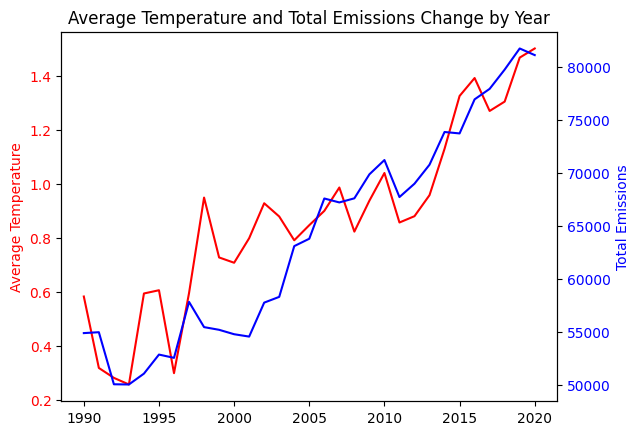

In [15]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(temperature_emission_year['Year'], temperature_emission_year['Average Temperature'], color='red', label='Average Temperature')
ax1.set_ylabel('Average Temperature', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(temperature_emission_year['Year'], temperature_emission_year['total_emission'], color='blue', label='Total Emissions')
ax2.set_ylabel('Total Emissions', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Average Temperature and Total Emissions Change by Year')
plt.xlabel('Year')
plt.show()

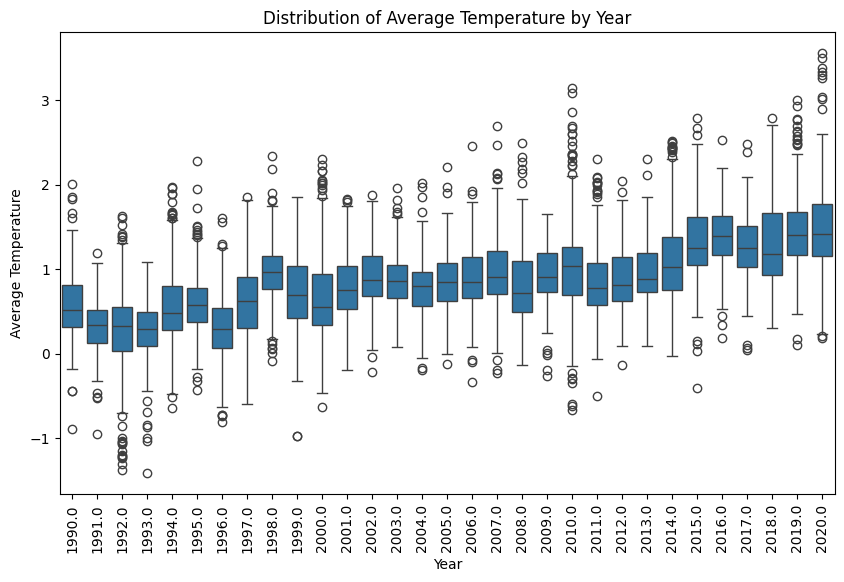

In [16]:
import seaborn as sns

pandas_df = emission_df.toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x='Year', y='Average Temperature', data=pandas_df)

plt.title('Distribution of Average Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.xticks(rotation=90)

plt.show()

In [17]:
emission_temperature_area = (emission_df
                            .groupBy("Area")
                            .agg(F.mean("Average Temperature").alias("Average Temperature"), 
                                 F.mean("total_emission").alias("total_emission"))
                            .orderBy("Area")) 

pandas_df = emission_temperature_area.toPandas()

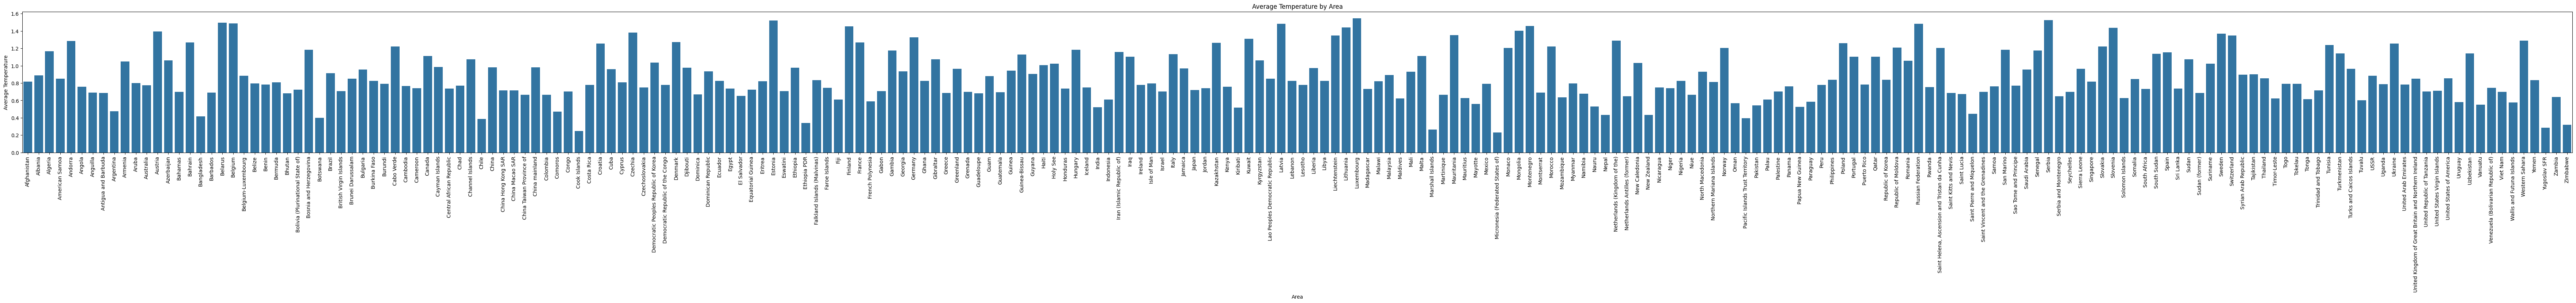

In [18]:
plt.figure(figsize=(90,5))
sns.barplot(x='Area', y='Average Temperature', data=pandas_df)

plt.title('Average Temperature by Area')
plt.xlabel('Area')
plt.ylabel('Average Temperature')
plt.xticks(rotation=90)

plt.show()

In [19]:
emission_sorted = emission_temperature_area.orderBy(F.desc("total_emission")).limit(50)

pandas_sorted_df = emission_sorted.toPandas()

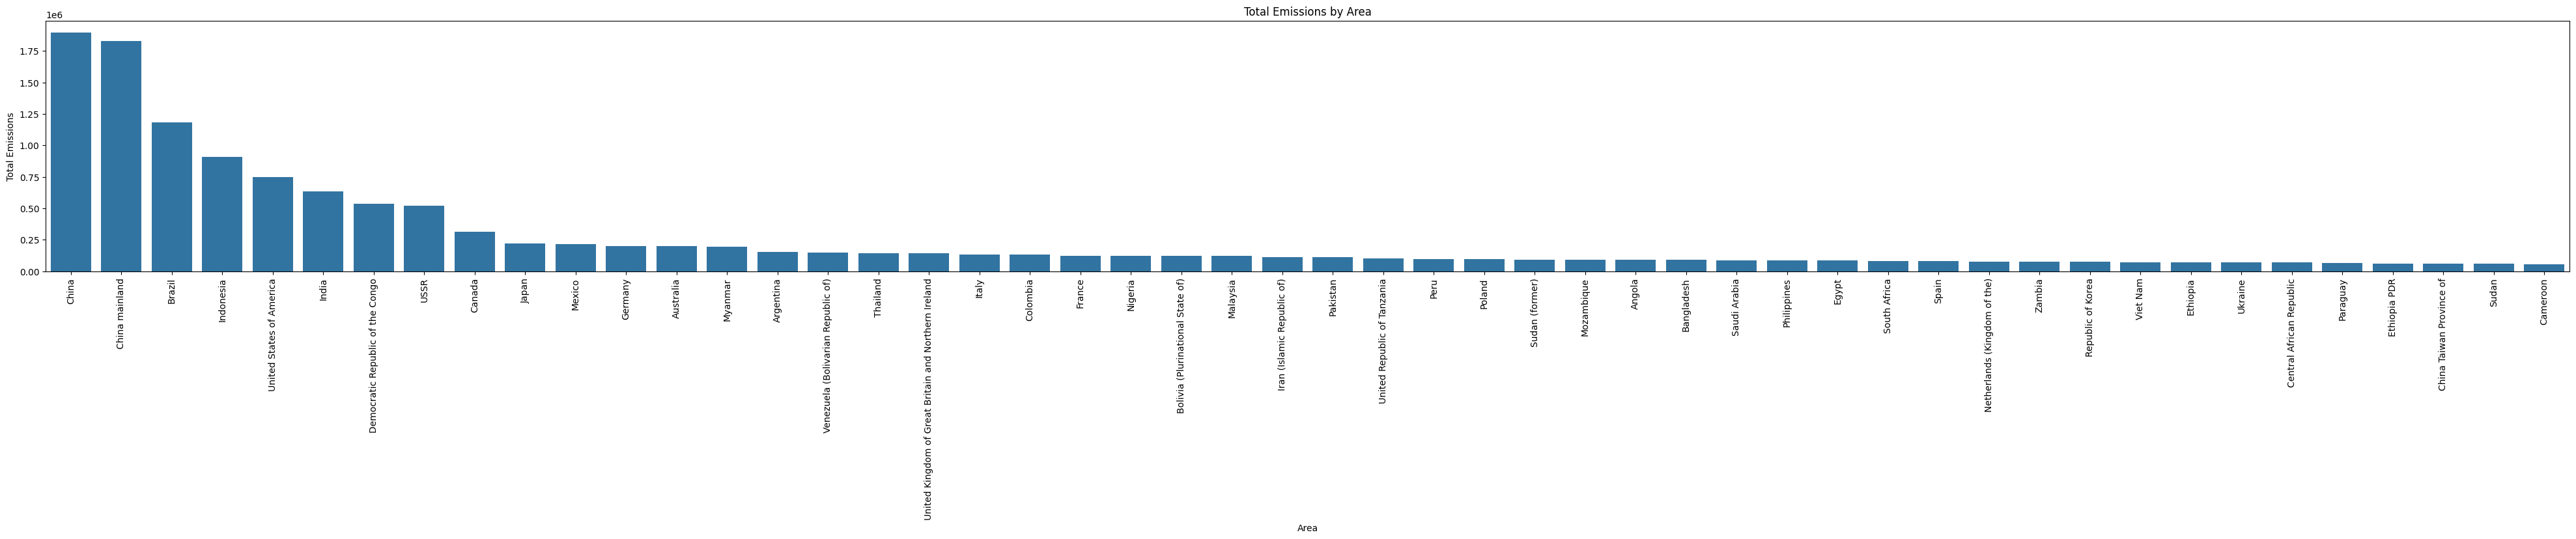

In [20]:
plt.figure(figsize=(50,5))
sns.barplot(x='Area', y='total_emission', data=pandas_sorted_df)

plt.title('Total Emissions by Area')
plt.xlabel('Area')
plt.ylabel('Total Emissions')
plt.xticks(rotation=90)

plt.show()

Verify data quality

In [21]:
missing_counts = emission_df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in emission_df.columns])

missing_counts.show()

+----+----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+
|Area|Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emission|Average Temperatu

In [22]:
from pyspark.sql.functions import col, count, when, approx_percentile

def compute_bounds(df, col_name):
    bounds = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    Q1 = bounds[0]
    Q3 = bounds[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Define numeric columns (assuming you have the column types or you can filter out non-numeric ones programmatically)
numeric_cols = [col_name for col_name, col_type in emission_df.dtypes if col_type != 'string']

outlier_flags = {}
for column in numeric_cols:
    lower, upper = compute_bounds(emission_df, column)
    outlier_flags[column] = (emission_df[column] < lower) | (emission_df[column] > upper)

# Construct the final DataFrame indicating outliers
outliers_df = emission_df.select(*[outlier_flags[col].alias(col) for col in numeric_cols])

# Show the outlier DataFrame
outliers_df.show()

+-----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+-----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+
| Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing| IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emission|Average Temperature|
+-

### 03-Data preparation
Data cleaning - Handling missing values

In [23]:
cols_to_impute = ['Savanna fires', 'Forest fires', 'Crop Residues',
                  'Rice Cultivation', 'Drained organic soils (CO2)',
                  'Pesticides Manufacturing', 'Food Transport', 'Forestland',
                  'Net Forest conversion', 'Food Household Consumption', 
                  'Food Retail', 'On-farm Electricity Use', 'Food Packaging',
                  'Agrifood Systems Waste Disposal', 'Food Processing',
                  'Fertilizers Manufacturing', 'IPPU', 
                  'Manure applied to Soils', 'Manure left on Pasture', 
                  'Manure Management', 'Fires in organic soils',
                  'Fires in humid tropical forests', 'On-farm energy use']

from pyspark.ml.feature import Imputer
from pyspark.sql.functions import lit

In [24]:
for col_name in cols_to_impute:
    median_value = emission_df.approxQuantile(col_name, [0.5], 0.1)[0]
    emission_df = emission_df.na.fill(median_value, [col_name])

In [25]:
missing_counts = emission_df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in emission_df.columns])

missing_counts.show()

+----+----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+
|Area|Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emission|Average Temperatu

Contruct data

In [26]:
from functools import reduce

cols_to_sum = ['Savanna fires', 'Forest fires', 'Crop Residues',
               'Rice Cultivation', 'Drained organic soils (CO2)',
               'Pesticides Manufacturing', 'Food Transport', 'Forestland',
               'Net Forest conversion', 'Food Household Consumption', 
               'Food Retail', 'On-farm Electricity Use', 'Food Packaging',
               'Agrifood Systems Waste Disposal', 'Food Processing',
               'Fertilizers Manufacturing', 'IPPU', 
               'Manure applied to Soils', 'Manure left on Pasture', 
               'Manure Management', 'Fires in organic soils',
               'Fires in humid tropical forests', 'On-farm energy use']

total_emission = reduce(lambda a, b: a + b, (F.col(c) for c in cols_to_sum))

emission_df = emission_df.withColumn('Updated_total_emission', total_emission)

In [27]:
emission_df.show()

+-----------+------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+----------------------+
|       Area|  Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|    IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On

In [28]:
from pyspark.sql.functions import round

summary = emission_df.describe()

for col_name in summary.columns:
    if col_name != 'summary':
        summary = summary.withColumn(col_name, round(summary[col_name], 2))

summary.show()

+-------+------+-------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+----------------------+
|summary|  Area|   Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|      IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropica

Integrate various data resources

In [29]:
agrifood_emission_df = emission_df.join(population_df, ['Area', 'Year', 'total_emission', 'Average Temperature'])
agrifood_emission_df.show()


+-----------+------+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+
|       Area|  Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|    IPPU|Man

In [30]:
agrifood_emission_df = agrifood_emission_df.withColumn('Total_population', 
                                                       agrifood_emission_df['Total Population - Female'] + agrifood_emission_df['Total Population - Male'])

agrifood_emission_df = agrifood_emission_df.withColumn('Emission_per_capita', 
                                                       agrifood_emission_df['Updated_total_emission'] / agrifood_emission_df['Total_population'])

agrifood_emission_df.show()

+-----------+------+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+----------------+--------------------+
|       Area|  Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|

In [31]:
from pyspark.sql.functions import isnan, when, count, col

agrifood_emission_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in agrifood_emission_df.columns]).show()

+----+----+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+----------------+-------------------+
|Area|Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturi

In [32]:

numeric_cols = [col_name for col_name, col_type in agrifood_emission_df.dtypes if col_type != 'string']

outlier_flags = {}
for column in numeric_cols:
    lower, upper = compute_bounds(agrifood_emission_df, column)
    outlier_flags[column] = (agrifood_emission_df[column] < lower) | (agrifood_emission_df[column] > upper)

outliers_df = agrifood_emission_df.select(*[outlier_flags[col].alias(col) for col in numeric_cols])

outliers_df.show()

+-----+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+-----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+----------------+-------------------+
| Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing| IPP

### 04-Data transformation
Feature selection

In [33]:
import matplotlib.pyplot as plt

cols = ['Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'total_emission', 'Average Temperature', 'Updated_total_emission',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'Total_population', 'Emission_per_capita']

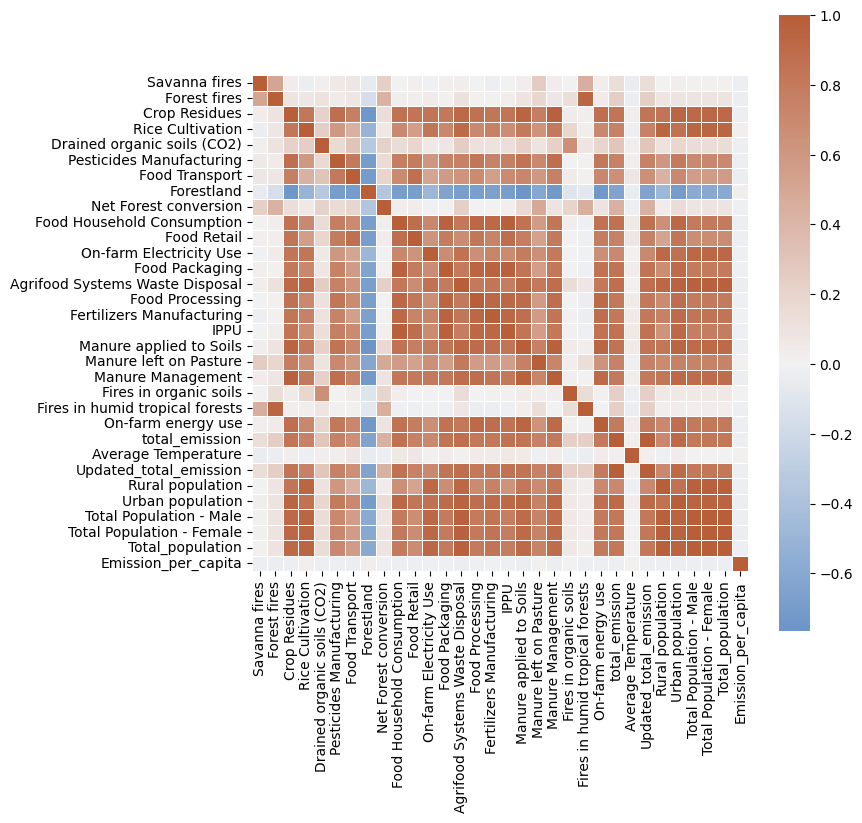

In [34]:
pandas_df = agrifood_emission_df.select(cols).toPandas()

corr = pandas_df.corr()

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=None, center=0, square=True, annot=False, linewidths=.5)

plt.show()

In [35]:
agrifood_emission_df.printSchema()

root
 |-- Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- total_emission: double (nullable = true)
 |-- Average Temperature: double (nullable = true)
 |-- Savanna fires: double (nullable = false)
 |-- Forest fires: double (nullable = false)
 |-- Crop Residues: double (nullable = false)
 |-- Rice Cultivation: double (nullable = false)
 |-- Drained organic soils (CO2): double (nullable = false)
 |-- Pesticides Manufacturing: double (nullable = false)
 |-- Food Transport: double (nullable = false)
 |-- Forestland: double (nullable = false)
 |-- Net Forest conversion: double (nullable = false)
 |-- Food Household Consumption: double (nullable = false)
 |-- Food Retail: double (nullable = false)
 |-- On-farm Electricity Use: double (nullable = false)
 |-- Food Packaging: double (nullable = false)
 |-- Agrifood Systems Waste Disposal: double (nullable = false)
 |-- Food Processing: double (nullable = false)
 |-- Fertilizers Manufacturing: double (nullable = false)
 |-

In [36]:
corr_avg_temp = corr['Average Temperature'].drop('Average Temperature')  # Drop the self-correlation
sorted_corr = corr_avg_temp.abs().sort_values(ascending=False)
print(sorted_corr)

Food Transport                     0.075724
Food Retail                        0.073404
IPPU                               0.062357
Food Household Consumption         0.055577
Food Processing                    0.053083
Forestland                         0.052053
Savanna fires                      0.046772
Manure applied to Soils            0.042311
Fertilizers Manufacturing          0.041462
Food Packaging                     0.040767
Forest fires                       0.039374
On-farm energy use                 0.039013
Fires in humid tropical forests    0.036910
Urban population                   0.036263
Manure Management                  0.032742
Drained organic soils (CO2)        0.029030
Pesticides Manufacturing           0.027960
Net Forest conversion              0.027359
Crop Residues                      0.025701
Fires in organic soils             0.023731
Rice Cultivation                   0.022532
Rural population                   0.019764
total_emission                  

In [37]:
sorted_corr = sorted_corr.drop('total_emission')

In [38]:
features = sorted_corr.head(25)

print(features)

Food Transport                     0.075724
Food Retail                        0.073404
IPPU                               0.062357
Food Household Consumption         0.055577
Food Processing                    0.053083
Forestland                         0.052053
Savanna fires                      0.046772
Manure applied to Soils            0.042311
Fertilizers Manufacturing          0.041462
Food Packaging                     0.040767
Forest fires                       0.039374
On-farm energy use                 0.039013
Fires in humid tropical forests    0.036910
Urban population                   0.036263
Manure Management                  0.032742
Drained organic soils (CO2)        0.029030
Pesticides Manufacturing           0.027960
Net Forest conversion              0.027359
Crop Residues                      0.025701
Fires in organic soils             0.023731
Rice Cultivation                   0.022532
Rural population                   0.019764
Updated_total_emission          

In [39]:
feature_names = features.index.tolist()
print(feature_names)

['Food Transport', 'Food Retail', 'IPPU', 'Food Household Consumption', 'Food Processing', 'Forestland', 'Savanna fires', 'Manure applied to Soils', 'Fertilizers Manufacturing', 'Food Packaging', 'Forest fires', 'On-farm energy use', 'Fires in humid tropical forests', 'Urban population', 'Manure Management', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Net Forest conversion', 'Crop Residues', 'Fires in organic soils', 'Rice Cultivation', 'Rural population', 'Updated_total_emission', 'Manure left on Pasture', 'Emission_per_capita']


Data scaling

In [40]:
from pyspark.sql.functions import mean, stddev, col

columns_to_scale = feature_names

agrifood_emission_df2 = agrifood_emission_df.select('Area', 'Year', 'Average Temperature',
                                                    'Food Transport', 'Food Retail', 'IPPU', 'Food Household Consumption', 'Food Processing', 'Forestland', 'Savanna fires', 'Manure applied to Soils', 'Fertilizers Manufacturing', 'Food Packaging', 'Forest fires', 'On-farm energy use', 'Fires in humid tropical forests', 'Urban population', 'Manure Management', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Net Forest conversion', 'Crop Residues', 'Fires in organic soils', 'Rice Cultivation', 'Rural population', 'Updated_total_emission', 'Manure left on Pasture', 'Emission_per_capita')

agrifood_emission_df2.show()

+-----------+------+-------------------+--------------+-----------+--------+--------------------------+---------------+----------+-------------+-----------------------+-------------------------+--------------+------------+------------------+-------------------------------+----------------+-----------------+---------------------------+------------------------+---------------------+-------------+----------------------+----------------+----------------+----------------------+----------------------+--------------------+
|       Area|  Year|Average Temperature|Food Transport|Food Retail|    IPPU|Food Household Consumption|Food Processing|Forestland|Savanna fires|Manure applied to Soils|Fertilizers Manufacturing|Food Packaging|Forest fires|On-farm energy use|Fires in humid tropical forests|Urban population|Manure Management|Drained organic soils (CO2)|Pesticides Manufacturing|Net Forest conversion|Crop Residues|Fires in organic soils|Rice Cultivation|Rural population|Updated_total_emission|M

In [41]:
from pyspark.ml.feature import VectorAssembler

feature_columns = agrifood_emission_df2.columns  
feature_columns.remove('Area')  
feature_columns.remove('Year')  
feature_columns.remove('Average Temperature')

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_vector = assembler.transform(agrifood_emission_df2)


In [42]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(feature_vector)
agrifood_dm_df = scalerModel.transform(feature_vector)


In [43]:
agrifood_dm_df.show()

+-----------+------+-------------------+--------------+-----------+--------+--------------------------+---------------+----------+-------------+-----------------------+-------------------------+--------------+------------+------------------+-------------------------------+----------------+-----------------+---------------------------+------------------------+---------------------+-------------+----------------------+----------------+----------------+----------------------+----------------------+--------------------+--------------------+--------------------+
|       Area|  Year|Average Temperature|Food Transport|Food Retail|    IPPU|Food Household Consumption|Food Processing|Forestland|Savanna fires|Manure applied to Soils|Fertilizers Manufacturing|Food Packaging|Forest fires|On-farm energy use|Fires in humid tropical forests|Urban population|Manure Management|Drained organic soils (CO2)|Pesticides Manufacturing|Net Forest conversion|Crop Residues|Fires in organic soils|Rice Cultivation

### 05-Data mining methods selection
Examine the correlation between carbon dioxide (CO2) emissions within the agri-food sector and the subsequent temperature rise:<br> regression analysis is utilised to investigate the association between carbon dioxide (CO2) emissions and the increase in temperature. This methodology facilitates the assessment of the magnitude and orientation of the association between the variables mentioned above.
<br><br>
Analyse the influence of various countries based on aggregated data on emissions and temperature change: <br>clustering techniques is utilised to categorise countries according to their emissions and temperature change data. This approach enables the identification of patterns and trends within the dataset, facilitating a comprehensive comprehension of the various countries' contributions to emissions and temperature fluctuations.
<br><br>
Identify the countries with the highest temperature increase and analyse their contributions to the overall environmental impact:<br> descriptive statistics is utilised to ascertain the nations exhibiting the greatest per capita emissions. After identifying these countries, decision tree analysis is used to gain insights into their contributions to the overall environmental impact.

### 06-Data mining algorithms selection
Load relevant algorithms

In [44]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### 07-Data mining
Regression

In [45]:
train_data, test_data = feature_vector.randomSplit([0.8, 0.2], seed=42)

print(f"Training Dataset Count: {train_data.count()}")
print(f"Test Dataset Count: {test_data.count()}")

Training Dataset Count: 5637
Test Dataset Count: 1328


In [46]:
# Initialize and train the model
rf = RandomForestRegressor(featuresCol="features", labelCol="Average Temperature")
model = rf.fit(train_data)

# Extract feature importances
importances = model.featureImportances

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

Food Transport: 0.10388567771410835
Food Retail: 0.13845840664615747
IPPU: 0.09756849492802079
Food Household Consumption: 0.011650557433638426
Food Processing: 0.020468620791487244
Forestland: 0.021417711481979358
Savanna fires: 0.011982699664777264
Manure applied to Soils: 0.0486979794219924
Fertilizers Manufacturing: 0.034425302938738696
Food Packaging: 0.02245301650225138
Forest fires: 0.07432614909344701
On-farm energy use: 0.02553827976484697
Fires in humid tropical forests: 0.045750639389667405
Urban population: 0.028462724512517846
Manure Management: 0.04322087333305886
Drained organic soils (CO2): 0.020803068315075876
Pesticides Manufacturing: 0.01641888747863425
Net Forest conversion: 0.022087130281621847
Crop Residues: 0.017191962990456187
Fires in organic soils: 0.009382175480377595
Rice Cultivation: 0.04602793345740469
Rural population: 0.03014692524355831
Updated_total_emission: 0.012721547730729898
Manure left on Pasture: 0.06545908866494009
Emission_per_capita: 0.031454

In [47]:
importances = model.featureImportances.toArray()

paired = list(zip(feature_names, importances))

sorted_features = sorted(paired, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


Food Retail: 0.13845840664615747
Food Transport: 0.10388567771410835
IPPU: 0.09756849492802079
Forest fires: 0.07432614909344701
Manure left on Pasture: 0.06545908866494009
Manure applied to Soils: 0.0486979794219924
Rice Cultivation: 0.04602793345740469
Fires in humid tropical forests: 0.045750639389667405
Manure Management: 0.04322087333305886
Fertilizers Manufacturing: 0.034425302938738696
Emission_per_capita: 0.031454146740511786
Rural population: 0.03014692524355831
Urban population: 0.028462724512517846
On-farm energy use: 0.02553827976484697
Food Packaging: 0.02245301650225138
Net Forest conversion: 0.022087130281621847
Forestland: 0.021417711481979358
Drained organic soils (CO2): 0.020803068315075876
Food Processing: 0.020468620791487244
Crop Residues: 0.017191962990456187
Pesticides Manufacturing: 0.01641888747863425
Updated_total_emission: 0.012721547730729898
Savanna fires: 0.011982699664777264
Food Household Consumption: 0.011650557433638426
Fires in organic soils: 0.009382

In [48]:
test_predictions = model.transform(test_data)

In [49]:
evaluator = RegressionEvaluator(labelCol="Average Temperature", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 0.498492998379684


Clustering

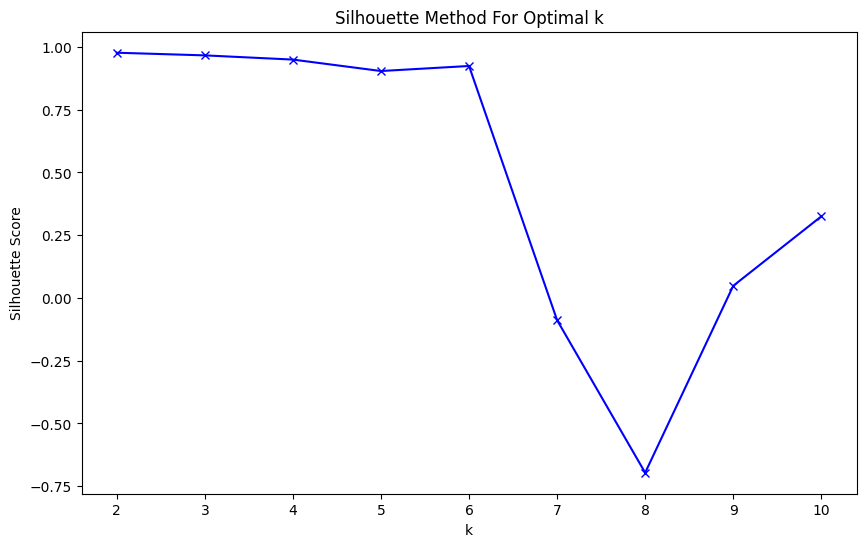

In [50]:
k_range = range(2, 11)
silhouette_list = []

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(agrifood_dm_df)
    predictions = model.transform(agrifood_dm_df)

    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

plt.figure(figsize=(10,6))
plt.plot(k_range, silhouette_list, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()


In [51]:
# Apply KMeans clustering with k=4
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("scaledFeatures")
model = kmeans.fit(agrifood_dm_df)
predictions = model.transform(agrifood_dm_df)

In [52]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for index, center in enumerate(centers):
    print(f"Cluster {index}: {center}")

Cluster Centers: 
Cluster 0: [ 0.24013637  0.13493625  0.06729975  0.0760308   0.08901841 -0.10251315
  0.21900354  0.13633069  0.15525106  0.04512808  0.22215241  0.10389359
  0.18451477  0.13075592  0.13309576  0.20180314  0.11112109  0.10949915
  0.10601614  0.04684556  0.13143806  0.08278887  0.1597646   0.25626289
  0.12066012]
Cluster 1: [ 5.72561399e+00  9.17729055e+00  1.27021114e+01  1.23534396e+01
  1.16627595e+01 -6.81610099e+00  6.27320098e-02  9.43150958e+00
  1.22303265e+01  1.31304145e+01  1.79158060e-01  9.73302694e+00
  3.87323032e-04  1.09998558e+01  8.62350581e+00  2.43051336e-01
  8.15191267e+00  0.00000000e+00  8.87403679e+00  0.00000000e+00
  8.36225251e+00  7.47530854e+00  1.08717379e+01  6.09797212e+00
  8.40334280e-04]
Cluster 2: [ 2.65304874e+00  2.49702968e+00  2.33962302e+00  2.73084827e+00
  3.34058148e+00 -2.95480365e+00  1.11059629e-01  6.19056996e+00
  4.20988278e+00  2.59931903e+00  8.00997533e-01  5.03544182e+00
  1.97927782e-01  5.65884889e+00  6.4381

In [53]:
cluster_assignments = predictions.groupBy("prediction").count().orderBy("prediction")
cluster_assignments.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 6806|
|         1|   34|
|         2|   61|
|         3|   64|
+----------+-----+



### 08-Interpretation
Regression

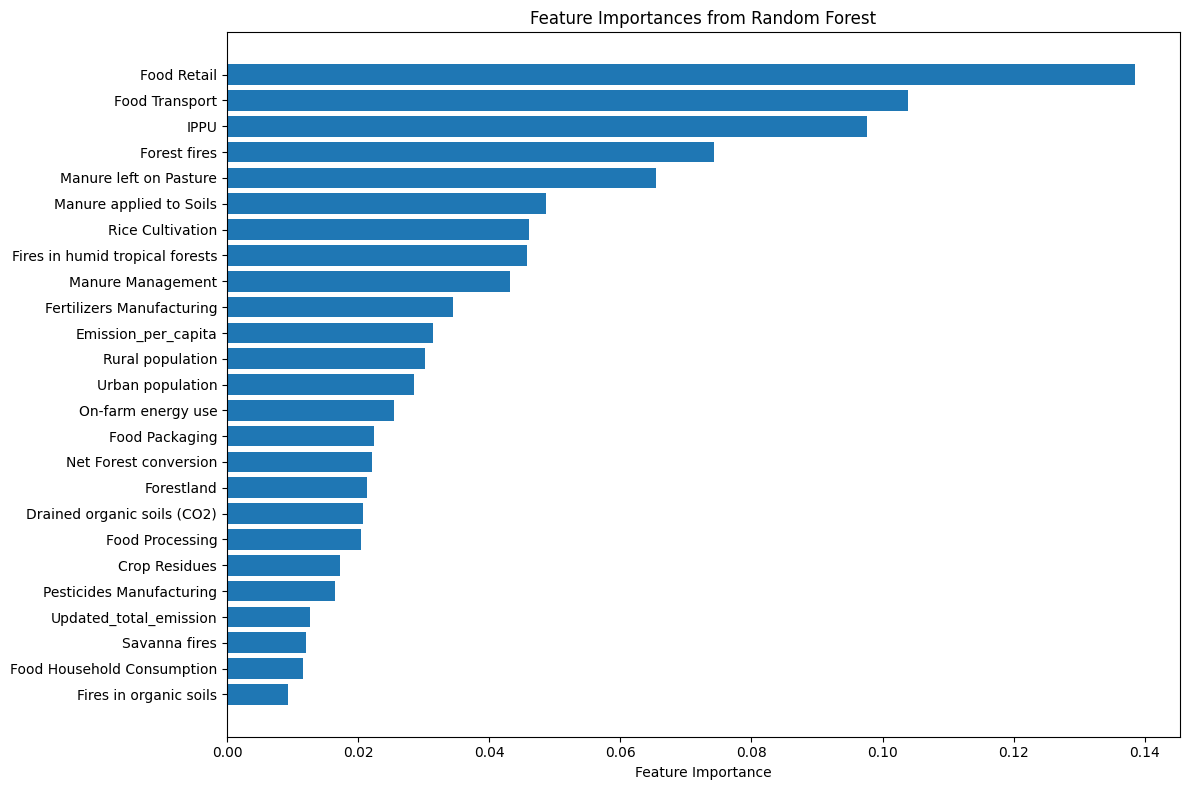

In [54]:
features, importance_values = zip(*sorted_features)

plt.figure(figsize=(12, 8))
plt.barh(features, importance_values, align='center')  
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  
plt.tight_layout()

Clustering

In [55]:
selected_data = predictions.select("Food Retail", "Average Temperature", "emission_per_capita", "Updated_total_emission", "prediction").collect()
food_retail_values, avg_temp_values, emission_per_capita_values, total_emission_values, cluster_predictions = zip(*[(x[0], x[1], x[2], x[3], x[4]) for x in selected_data])

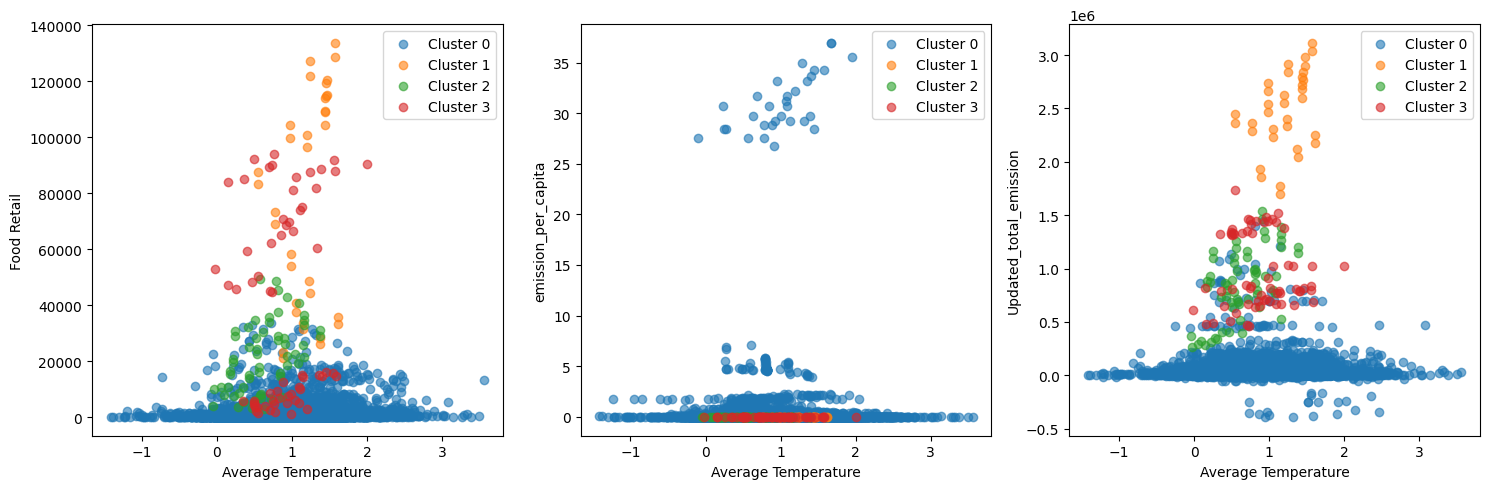

In [56]:
plt.figure(figsize=(15, 5))

# Subplot 1: Food Retail vs. Average Temperature
plt.subplot(1, 3, 1)
for i in range(4):  
    y_vals = [food_retail_values[j] for j in range(len(food_retail_values)) if cluster_predictions[j] == i]
    x_vals = [avg_temp_values[j] for j in range(len(avg_temp_values)) if cluster_predictions[j] == i]
    plt.scatter(x_vals, y_vals, label=f'Cluster {i}', alpha=0.6)
plt.xlabel('Average Temperature')
plt.ylabel('Food Retail')
plt.legend()

# Subplot 2: Average Temperature vs. emission_per_capita
plt.subplot(1, 3, 2)
for i in range(4):  
    x_vals = [avg_temp_values[j] for j in range(len(avg_temp_values)) if cluster_predictions[j] == i]
    y_vals = [emission_per_capita_values[j] for j in range(len(emission_per_capita_values)) if cluster_predictions[j] == i]
    plt.scatter(x_vals, y_vals, label=f'Cluster {i}', alpha=0.6)
plt.xlabel('Average Temperature')
plt.ylabel('emission_per_capita')
plt.legend()

# Subplot 3: Average Temperature vs. Updated_total_emission
plt.subplot(1, 3, 3)
for i in range(4): 
    x_vals = [avg_temp_values[j] for j in range(len(avg_temp_values)) if cluster_predictions[j] == i]
    y_vals = [total_emission_values[j] for j in range(len(total_emission_values)) if cluster_predictions[j] == i]
    plt.scatter(x_vals, y_vals, label=f'Cluster {i}', alpha=0.6)
plt.xlabel('Average Temperature')
plt.ylabel('Updated_total_emission')
plt.legend()

plt.tight_layout()
plt.show()

Descriptive statistic

In [57]:
agrifood_2020 = agrifood_emission_df.filter(agrifood_emission_df['Year'] == 2020)

from pyspark.sql import functions as F
temperature_2020 = agrifood_2020.orderBy(F.desc('Average Temperature')).limit(30)

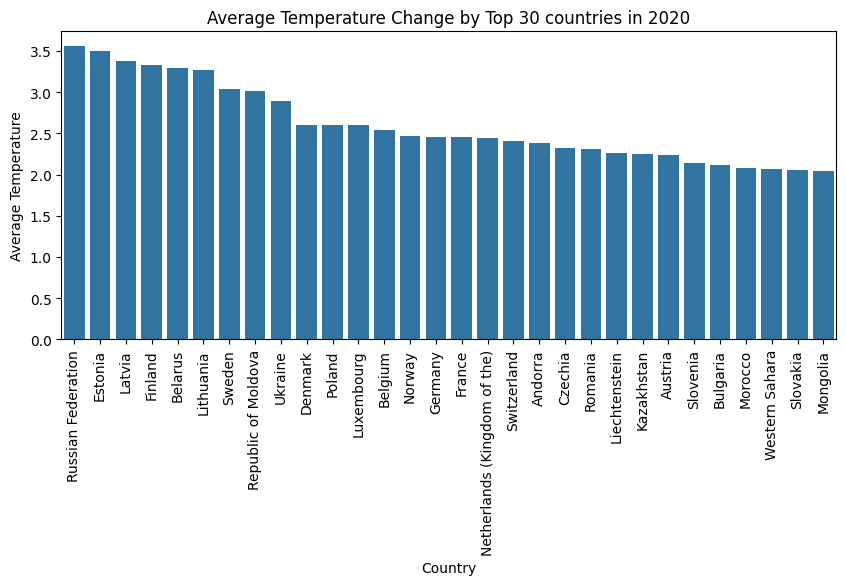

In [58]:
import seaborn as sns

plot_data = temperature_2020.select('Area', 'Average Temperature').toPandas()

plt.figure(figsize=(10,4))
sns.barplot(x='Area', y='Average Temperature', data=plot_data)
plt.title('Average Temperature Change by Top 30 countries in 2020')
plt.xlabel('Country')
plt.ylabel('Average Temperature')
plt.xticks(rotation=90)
plt.show()

In [59]:
emission_2020 = agrifood_2020.orderBy(F.desc('Updated_total_emission')).limit(30)

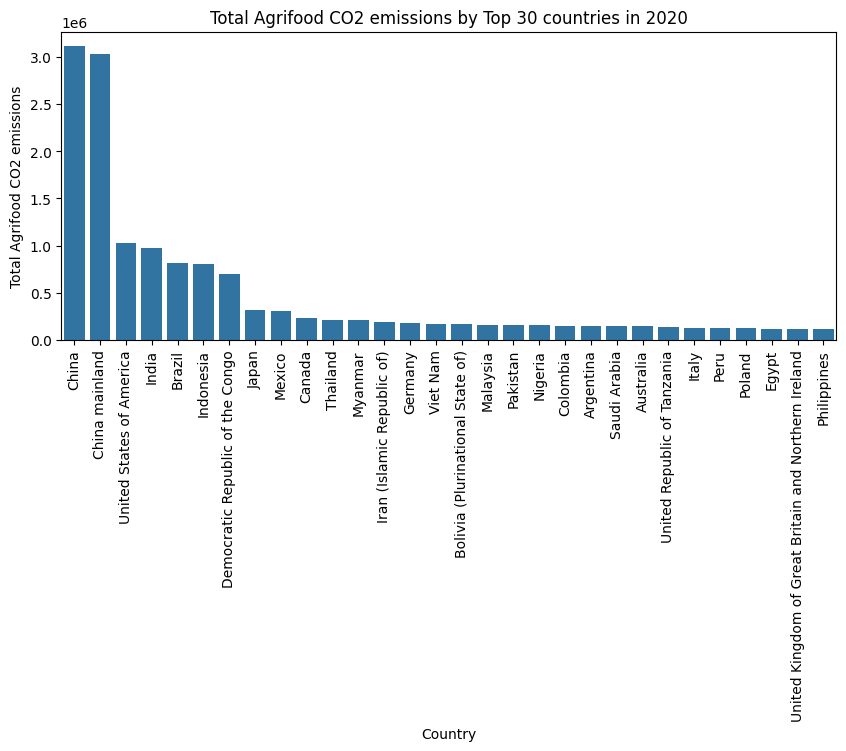

In [60]:
plot_data = emission_2020.select('Area', 'Updated_total_emission').toPandas()

plt.figure(figsize=(10,4))
sns.barplot(x='Area', y='Updated_total_emission', data=plot_data)
plt.title('Total Agrifood CO2 emissions by Top 30 countries in 2020')
plt.xlabel('Country')
plt.ylabel('Total Agrifood CO2 emissions')
plt.xticks(rotation=90)
plt.show()

In [61]:
emission_per_capita = agrifood_2020.orderBy(F.desc('Emission_per_capita')).limit(30)

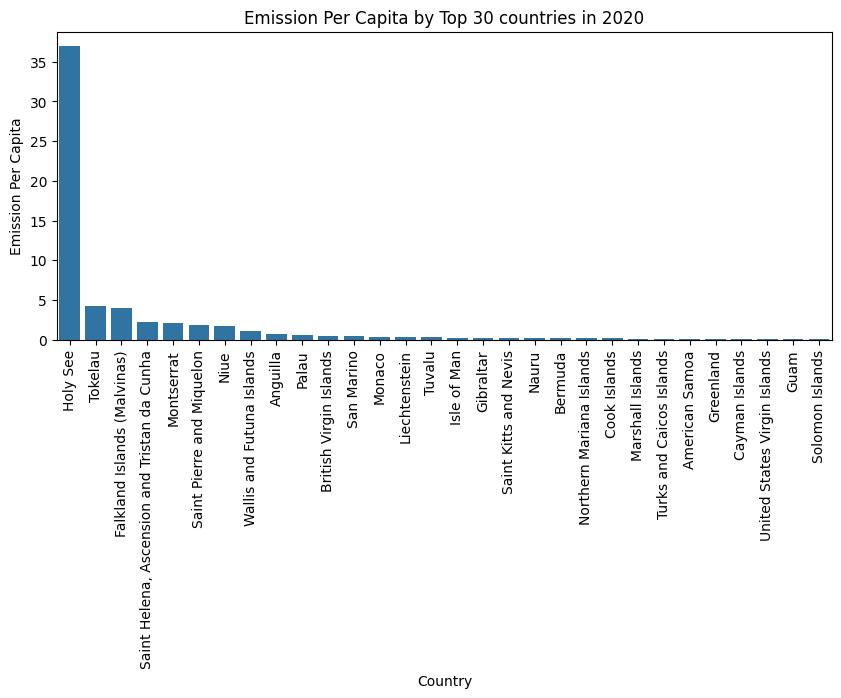

In [62]:
plot_data = emission_per_capita.select('Area', 'Emission_per_capita').toPandas()

plt.figure(figsize=(10,4))
sns.barplot(x='Area', y='Emission_per_capita', data=plot_data)
plt.title('Emission Per Capita by Top 30 countries in 2020')
plt.xlabel('Country')
plt.ylabel('Emission Per Capita')
plt.xticks(rotation=90)
plt.show()

In [63]:
russian_federation_data = agrifood_2020.filter(agrifood_2020['Area'] == 'Russian Federation') \
                                       .select('Area', 'Average Temperature', 'Updated_total_emission', 'Emission_per_capita')

russian_federation_data.show()


+------------------+-------------------+----------------------+--------------------+
|              Area|Average Temperature|Updated_total_emission| Emission_per_capita|
+------------------+-------------------+----------------------+--------------------+
|Russian Federation|        3.558083333|    34468.790900000015|2.367080303794615...|
+------------------+-------------------+----------------------+--------------------+



In [64]:
china_data = agrifood_2020.filter(agrifood_2020['Area'] == 'China') \
                                       .select('Area', 'Average Temperature', 'Updated_total_emission', 'Emission_per_capita')

china_data.show()

+-----+-------------------+----------------------+--------------------+
| Area|Average Temperature|Updated_total_emission| Emission_per_capita|
+-----+-------------------+----------------------+--------------------+
|China|              1.574|          3115113.7488|0.002138137716844574|
+-----+-------------------+----------------------+--------------------+



In [65]:
# Set up the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])  # Number of trees
             .addGrid(rf.maxDepth, [5, 10, 20])   # Maximum depth of each tree
             .build())

# Set up 5-fold cross validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="Average Temperature"),
                          numFolds=5)

cvModel = crossval.fit(feature_vector)
bestModel = cvModel.bestModel

In [66]:
best_importances = bestModel.featureImportances
paired = list(zip(feature_names, best_importances))
sorted_features = sorted(paired, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"{feature}: {importance}") 

Food Retail: 0.08573924600041849
Food Transport: 0.061773344479291316
IPPU: 0.05387587730418323
Emission_per_capita: 0.053609272533391476
Manure left on Pasture: 0.05180171826414463
Forest fires: 0.04963162841698903
Rice Cultivation: 0.04682953853135529
On-farm energy use: 0.04377633312460344
Fertilizers Manufacturing: 0.0436019124992591
Pesticides Manufacturing: 0.04227081112285545
Food Household Consumption: 0.04164271903181559
Savanna fires: 0.04133109872526139
Updated_total_emission: 0.040755094342541265
Food Packaging: 0.039045371911786544
Rural population: 0.03569253644943484
Food Processing: 0.035686565486168845
Manure applied to Soils: 0.0342668303004297
Urban population: 0.03381918596856676
Crop Residues: 0.033171198267981455
Manure Management: 0.03173731551007057
Forestland: 0.02961681185319776
Drained organic soils (CO2): 0.02426136637389842
Net Forest conversion: 0.023276478049852917
Fires in humid tropical forests: 0.01862924621610925
Fires in organic soils: 0.004158499236

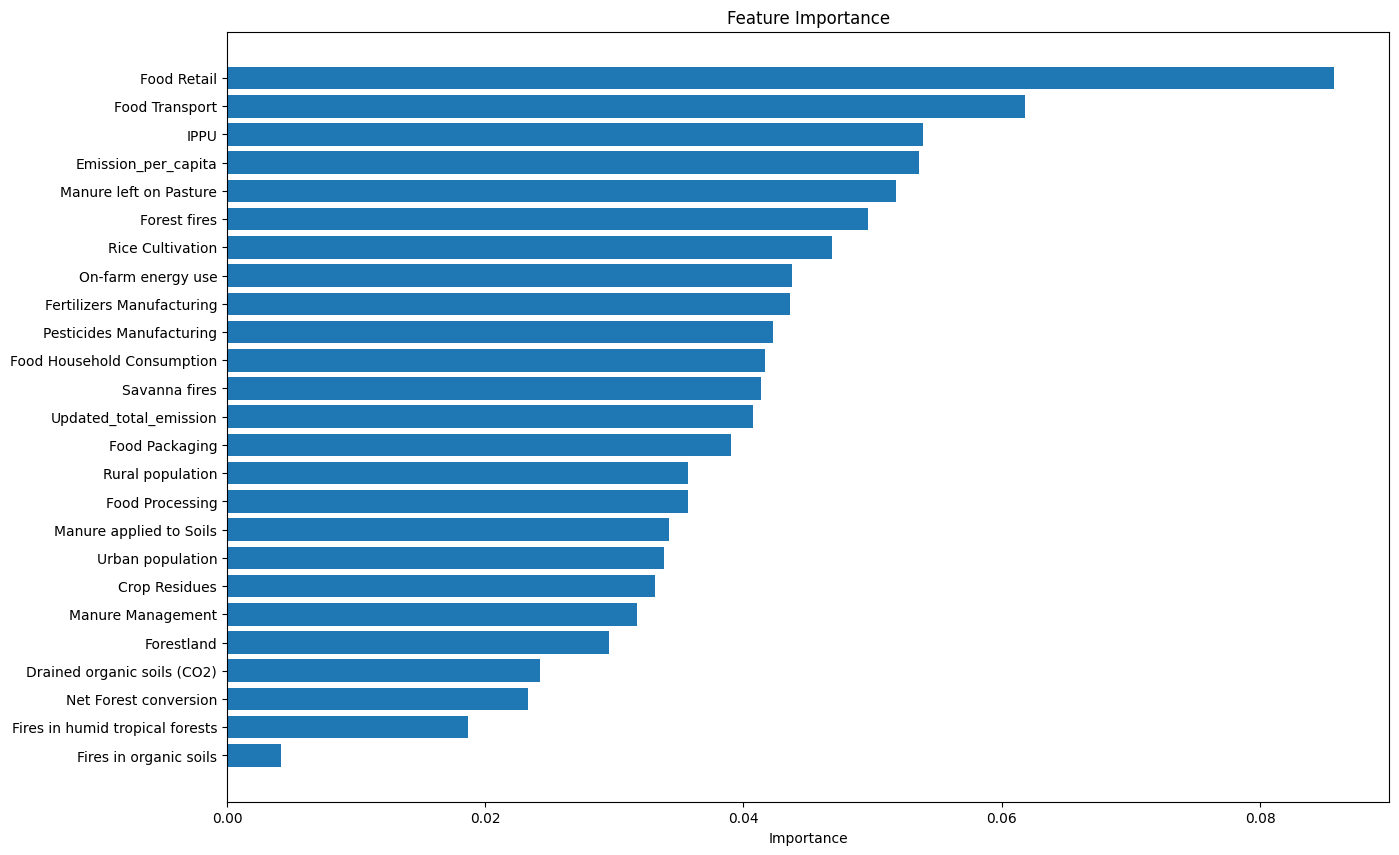

In [67]:
features, importance = zip(*sorted_features)

plt.figure(figsize=(15, 10))
plt.barh(features, importance, align='center')
plt.gca().invert_yaxis()  
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

09-ACT<br>
Describe the Action Plan to Implement, Observe and Improve